# Final Tutorial: Spotify Data

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
import statsmodels.graphics.regressionplots as smg
from sklearn.preprocessing import PolynomialFeatures
import sklearn
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.svm import LinearSVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
from sklearn.neighbors import KNeighborsRegressor

mpl.rcParams['agg.path.chunksize'] = 10000

In [132]:
pip install recordlinkage

Note: you may need to restart the kernel to use updated packages.


In [133]:
import recordlinkage

In [4]:
top_path = "./BillboardFromLast20/billboardHot100_1999-2019.csv"
top_data = pd.read_csv(top_path)
top_data = top_data.drop(['Unnamed: 0', 'Writing.Credits', 'Lyrics', 'Features'], axis=1)
top_data.head()

,Artists,Name,Weekly.rank,Peak.position,Weeks.on.chart,Week,Date,Genre
0,"Lil Nas,",Old Town Road,1,1.0,7.0,2019-07-06,"April 5, 2019","Country,Atlanta,Alternative Country,Hip-Hop,Tr..."
1,"Shawn Mendes, Camila Cabello",Senorita,2,NaN,NaN,2019-07-06,"June 21, 2019",Pop
2,Billie Eilish,Bad Guy,3,2.0,13.0,2019-07-06,"March 29, 2019","Hip-Hop,Dark Pop,House,Trap,Memes,Alternative ..."
3,Khalid,Talk,4,3.0,20.0,2019-07-06,"February 7, 2019","Synth-Pop,Pop"
4,"Ed Sheeran, Justin Bieber",I Don't Care,5,2.0,7.0,2019-07-06,"May 10, 2019","Canada,UK,Dance,Dance-Pop,Pop"


In [5]:
attr_path = "./spotify-dataset-19212020-160k-tracks/data.csv"
attr_data = pd.read_csv(attr_path)
attr_data = attr_data[(attr_data['year'] >= 2015)]
attr_data.head()

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
18606,0.518,2015,0.00543,['BØRNS'],0.611,218107,0.797,0,2GiJYvgVaD2HtM8GqD9EgQ,0.001370,6,0.2600,-7.627,0,Electric Love,87,2015-10-16,0.0533,120.041
18607,0.337,2015,0.06780,['The Neighbourhood'],0.588,260173,0.521,0,5E30LdtzQTGqRvNd7l6kG5,0.149000,10,0.1230,-9.461,1,Daddy Issues,86,2015-10-30,0.0329,85.012
18608,0.785,2015,0.01150,['Tame Impala'],0.640,216320,0.740,1,6K4t31amVTZDgR3sKmwUJJ,0.006780,4,0.1670,-4.083,1,The Less I Know The Better,85,2015-07-17,0.0284,116.879
18609,0.512,2015,0.20500,['Chris Stapleton'],0.392,293293,0.370,0,3fqwjXwUGN6vbzIwvyFMhx,0.009600,9,0.0821,-10.888,1,Tennessee Whiskey,79,2015-05-04,0.0298,48.718
18610,0.672,2015,0.03710,['WILLOW'],0.764,196520,0.705,0,0y60itmpH0aPKsFiGxmtnh,0.000019,3,0.0943,-5.279,0,Wait a Minute!,83,2015-01-11,0.0278,101.003


In [6]:
top_data['Date'] = pd.to_datetime(top_data['Date'])
top_data['Year'] = top_data['Date'].apply(lambda date: date.year)
attr_data['release_date'] = pd.to_datetime(attr_data['release_date'])

In [7]:
top_data = top_data[top_data['Year'] >= 2015]

In [8]:
f = {'Weekly.rank': 'min', 'Peak.position': 'min', 'Weeks.on.chart': 'max', 'Genre': 'first'}
top_data = top_data.groupby(['Artists', 'Name', 'Year'], as_index = False).agg(f)

In [9]:
f = {'valence': 'mean',
     'acousticness': 'mean',
     'danceability': 'mean',
     'duration_ms': 'mean',
     'energy': 'mean',
     'explicit': 'max',
     'instrumentalness': 'mean',
     'key': 'first',
     'liveness': 'mean',
     'loudness': 'mean',
     'mode': 'first',
     'popularity': 'mean',
     'speechiness': 'mean',
     'tempo': 'mean',
    }
attr_data = attr_data.groupby(['artists', 'name', 'year'], as_index = False).agg(f)

In [10]:
def first_artist_top(artists):
    return artists.split(',')[0]

def first_artist_attr(artists):
    return artists.split('\'')[1]

In [11]:
top_data['join_artists'] = top_data['Artists'].apply(first_artist_top)
attr_data['join_artists'] = attr_data['artists'].apply(first_artist_attr)

In [176]:
indexer = recordlinkage.Index()
indexer.block(left_on='Year', right_on='year')
candidates = indexer.index(top_data, attr_data)
print(len(candidates))

3676644


In [177]:
compare = recordlinkage.Compare()
compare.string('Name', 'name', threshold=0.85, label='Name')
compare.string('join_artists', 'join_artists', method='jarowinkler', threshold=0.85, label='join_artists')
features = compare.compute(candidates, top_data, attr_data)

In [178]:
features.sum(axis=1).value_counts().sort_index(ascending=False)

2.0        877
1.0      14025
0.0    3661742
dtype: int64

In [179]:
potential_matches = features[features.sum(axis=1) > 1].reset_index()
potential_matches['Score'] = potential_matches.loc[:, 'Name':'join_artists'].sum(axis=1)

In [180]:
potential_matches

,level_0,level_1,Name,join_artists,Score
0,10,191,1.0,1.0,2.0
1,19,205,1.0,1.0,2.0
2,32,232,1.0,1.0,2.0
3,33,233,1.0,1.0,2.0
4,36,255,1.0,1.0,2.0
...,...,...,...,...,...
872,1851,11020,1.0,1.0,2.0
873,1853,11022,1.0,1.0,2.0
874,1854,11023,1.0,1.0,2.0
875,1869,11061,1.0,1.0,2.0


In [204]:
top_data.loc[1593, :]

Artists                      Shawn Mendes, Camila Cabello
Name                                             Senorita
Year                                                 2019
Weekly.rank                                             2
Peak.position                                         NaN
Weeks.on.chart                                        NaN
Genre                                                 Pop
join_artists                                 Shawn Mendes
Song              Shawn Mendes, Camila Cabello - Senorita
Name: 1593, dtype: object

In [184]:
attr_data.loc[191, :]

artists             ['21 Savage']
name                          1.5
year                         2018
valence                     0.306
acousticness             0.000244
danceability                0.885
duration_ms                148656
energy                       0.52
explicit                        1
instrumentalness         1.16e-06
key                             1
liveness                    0.454
loudness                   -8.353
mode                            1
popularity                     60
speechiness                 0.359
tempo                      84.022
join_artists            21 Savage
Name: 191, dtype: object

In [187]:
potential_matches.to_csv('matched_data.csv', index=False)  

In [12]:
data_path = "./matched_data.csv"
data = pd.read_csv(data_path)
data.head()

,level_0,level_1,Name,join_artists,Score
0,10,191,1.0,1.0,2.0
1,19,205,1.0,1.0,2.0
2,32,232,1.0,1.0,2.0
3,33,233,1.0,1.0,2.0
4,36,255,1.0,1.0,2.0


In [13]:
top_data['Song'] = top_data[['Artists', 'Name']].apply(lambda x: ' - '.join(x), axis=1)
attr_data['Song'] = attr_data[['artists', 'name']].apply(lambda x: ' - '.join(x), axis=1)

In [14]:
top_data_lookup = top_data[['Song']]
attr_data_lookup = attr_data[['Song']]

In [15]:
merged_data = data.join(top_data_lookup, on='level_0', rsuffix = '_top')

In [16]:
merged_data = merged_data.join(attr_data_lookup, on='level_1', lsuffix = '_top', rsuffix = '_attr')

In [17]:
merged_data

,level_0,level_1,Name,join_artists,Score,Song_top,Song_attr
0,10,191,1.0,1.0,2.0,21 Savage - 1.5,['21 Savage'] - 1.5
1,19,205,1.0,1.0,2.0,21 Savage - Monster,['21 Savage'] - monster
2,32,232,1.0,1.0,2.0,5 Seconds Of Summer - Want You Back,['5 Seconds of Summer'] - Want You Back
3,33,233,1.0,1.0,2.0,5 Seconds Of Summer - Youngblood,['5 Seconds of Summer'] - Youngblood
4,36,255,1.0,1.0,2.0,6ix9ine - BEBE,"['6ix9ine', 'Anuel AA'] - BEBE"
...,...,...,...,...,...,...,...
872,1851,11020,1.0,1.0,2.0,Zac Brown Band - Beautiful Drug,['Zac Brown Band'] - Beautiful Drug
873,1853,11022,1.0,1.0,2.0,Zac Brown Band - Homegrown,['Zac Brown Band'] - Homegrown
874,1854,11023,1.0,1.0,2.0,Zac Brown Band - Loving You Easy,['Zac Brown Band'] - Loving You Easy
875,1869,11061,1.0,1.0,2.0,Zedd - Beautiful Now,"['Zedd', 'Jon Bellion'] - Beautiful Now"


In [194]:
merged_data.to_csv('merged_data.csv', index=False)

Here, we sifted through the values manually to find if there were any duplicate matches.

In [206]:
merged_data[merged_data['Song_top'] == 'MAX - Lights Down Low']

,level_0,level_1,Name,join_artists,Score,Song_top,Song_attr
548,1199,6539,1.0,1.0,2.0,MAX - Lights Down Low,"['MAX', 'gnash'] - Lights Down Low"
549,1199,6540,1.0,1.0,2.0,MAX - Lights Down Low,['MAX'] - Lights Down Low


In [207]:
merged_data[merged_data['Song_top'] == 'Fall Out Boy - Irresistible']

,level_0,level_1,Name,join_artists,Score,Song_top,Song_attr
764,601,3251,1.0,1.0,2.0,Fall Out Boy - Irresistible,"['Fall Out Boy', 'Demi Lovato'] - Irresistible"
765,601,3257,1.0,1.0,2.0,Fall Out Boy - Irresistible,['Fall Out Boy'] - Irresistible


The version of "Lights Down Low" that made it onto Billboard was the version with gnash. The version of "Irresistible" that made it onto Billboard was the version without Demi Lovato.

In [18]:
data = data.drop([549, 764])

We shift back to using the "data" dataframe, to avoid duplicate "Song" features when joining.

In [19]:
data

,level_0,level_1,Name,join_artists,Score
0,10,191,1.0,1.0,2.0
1,19,205,1.0,1.0,2.0
2,32,232,1.0,1.0,2.0
3,33,233,1.0,1.0,2.0
4,36,255,1.0,1.0,2.0
...,...,...,...,...,...
872,1851,11020,1.0,1.0,2.0
873,1853,11022,1.0,1.0,2.0
874,1854,11023,1.0,1.0,2.0
875,1869,11061,1.0,1.0,2.0


In [20]:
data = data.join(top_data, on='level_0', lsuffix = '_match', rsuffix = '_top')

In [21]:
data = data.join(attr_data, on='level_1', lsuffix = '_top', rsuffix = '_attr')

In [22]:
data

,level_0,level_1,Name_match,join_artists_match,Score,Artists,Name_top,Year,Weekly.rank,Peak.position,...,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,join_artists,Song_attr
0,10,191,1.0,1.0,2.0,21 Savage,1.5,2018.0,86,NaN,...,0.000001,1,0.4540,-8.353,1,60.0,0.3590,84.022,21 Savage,['21 Savage'] - 1.5
1,19,205,1.0,1.0,2.0,21 Savage,Monster,2018.0,73,73.0,...,0.000228,9,0.1180,-6.916,0,65.0,0.1240,134.022,21 Savage,['21 Savage'] - monster
2,32,232,1.0,1.0,2.0,5 Seconds Of Summer,Want You Back,2018.0,61,NaN,...,0.000001,0,0.2020,-4.915,1,66.0,0.0439,98.030,5 Seconds of Summer,['5 Seconds of Summer'] - Want You Back
3,33,233,1.0,1.0,2.0,5 Seconds Of Summer,Youngblood,2018.0,7,7.0,...,0.000000,7,0.1240,-5.114,0,78.5,0.4630,120.274,5 Seconds of Summer,['5 Seconds of Summer'] - Youngblood
4,36,255,1.0,1.0,2.0,6ix9ine,BEBE,2018.0,30,30.0,...,0.000000,0,0.1250,-3.559,1,73.0,0.1090,102.063,6ix9ine,"['6ix9ine', 'Anuel AA'] - BEBE"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
872,1851,11020,1.0,1.0,2.0,Zac Brown Band,Beautiful Drug,2015.0,52,52.0,...,0.000003,8,0.1240,-5.243,0,58.0,0.0808,125.943,Zac Brown Band,['Zac Brown Band'] - Beautiful Drug
873,1853,11022,1.0,1.0,2.0,Zac Brown Band,Homegrown,2015.0,35,35.0,...,0.000113,6,0.1350,-3.742,1,69.0,0.0290,105.006,Zac Brown Band,['Zac Brown Band'] - Homegrown
874,1854,11023,1.0,1.0,2.0,Zac Brown Band,Loving You Easy,2015.0,40,40.0,...,0.000004,1,0.0671,-3.985,1,62.0,0.0275,98.995,Zac Brown Band,['Zac Brown Band'] - Loving You Easy
875,1869,11061,1.0,1.0,2.0,Zedd,Beautiful Now,2015.0,64,64.0,...,0.000015,11,0.0740,-4.126,0,71.0,0.0282,128.003,Zedd,"['Zedd', 'Jon Bellion'] - Beautiful Now"


In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 875 entries, 0 to 876
Data columns (total 33 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   level_0             875 non-null    int64  
 1   level_1             875 non-null    int64  
 2   Name_match          875 non-null    float64
 3   join_artists_match  875 non-null    float64
 4   Score               875 non-null    float64
 5   Artists             875 non-null    object 
 6   Name_top            875 non-null    object 
 7   Year                875 non-null    float64
 8   Weekly.rank         875 non-null    int64  
 9   Peak.position       698 non-null    float64
 10  Weeks.on.chart      698 non-null    float64
 11  Genre               875 non-null    object 
 12  join_artists_top    875 non-null    object 
 13  Song_top            875 non-null    object 
 14  artists             875 non-null    object 
 15  name                875 non-null    object 
 16  year    

In [24]:
data = data.drop(['level_0',
                  'level_1',
                  'Name_match',
                  'Artists',
                  'Name_top',
                  'Year',
                  'Peak.position',
                  'join_artists_match',
                  'Score',
                  'join_artists_top',
                  'Song_top',
                  'Song_attr',
                  'join_artists'
                 ], axis=1)

In [25]:
old_col_names = ['Weekly.rank', 'Weeks.on.chart', 'Genre', 'artists', 'name', 'year',
       'valence', 'acousticness', 'danceability', 'duration_ms', 'energy',
       'explicit', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'popularity', 'speechiness', 'tempo']

new_col_names = ['peak_pos', 'weeks_on_chart', 'genre', 'artists', 'name', 'year',
       'valence', 'acousticness', 'danceability', 'duration_ms', 'energy',
       'explicit', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'popularity', 'speechiness', 'tempo']

res = {old_col_names[i]: new_col_names[i] for i in range(len(old_col_names))}
data.rename(res, axis=1, inplace=True)

In [26]:
data.dropna(inplace=True)

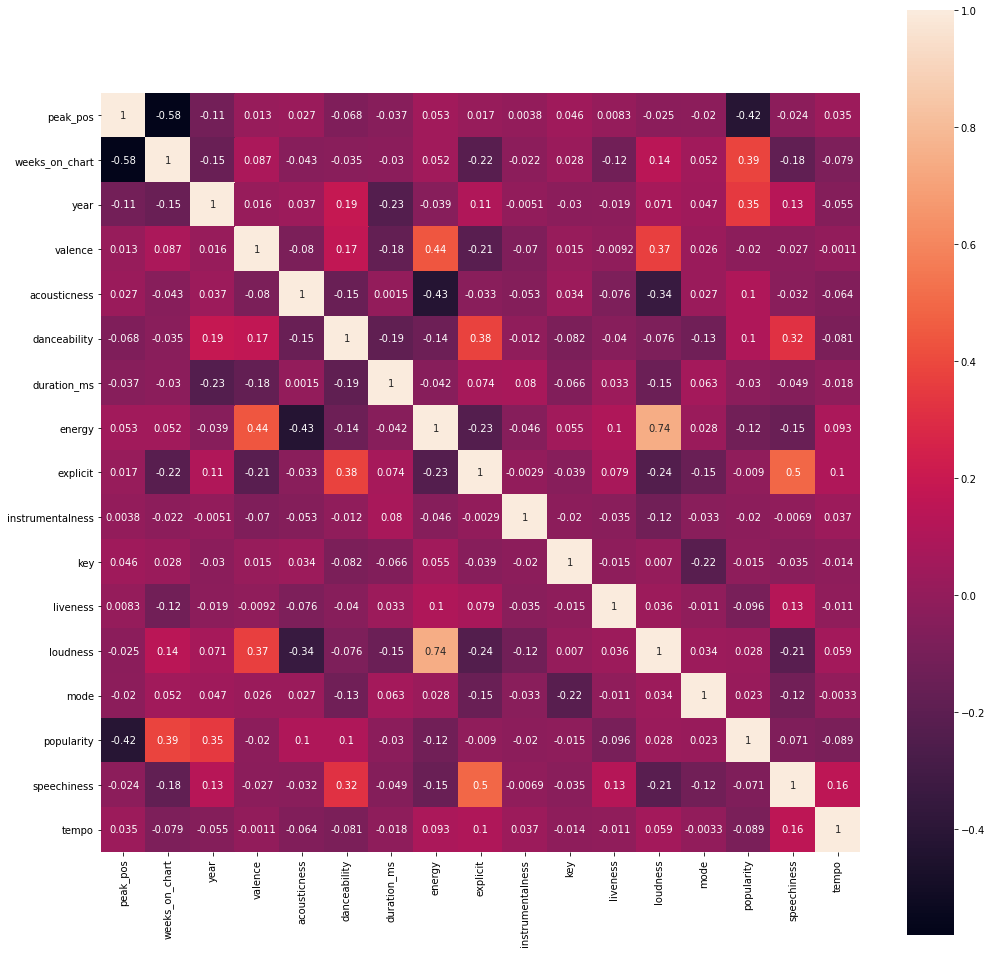

In [27]:
corr = data.corr()
fig, ax = plt.subplots()
fig.set_size_inches(17, 17)
sns.heatmap(corr, annot=True, fmt=".2g", ax=ax, square=True)

[-1.81961655e-03  3.93140661e-01 -2.94326915e+01  7.96077215e+02]
0.17849178055090703


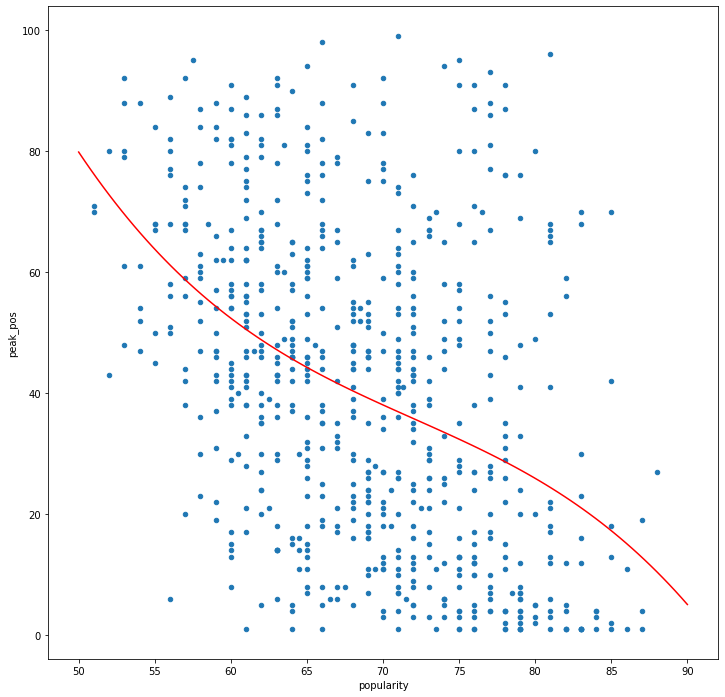

In [83]:
fig = plt.figure()
ax = fig.add_subplot(111)

coeffs = np.polyfit(x = data.popularity, y = data.peak_pos, deg=3)
print(coeffs)


x = data.popularity
y = data.peak_pos

# r-squared
p = np.poly1d(coeffs)
# fit values, and mean
yhat = p(x)                         # or [p(z) for z in x]
ybar = np.sum(y)/len(y)          # or sum(y)/len(y)
ssreg = np.sum((yhat-ybar)**2)   # or sum([ (yihat - ybar)**2 for yihat in yhat])
sstot = np.sum((y - ybar)**2)    # or sum([ (yi - ybar)**2 for yi in y])
determination = ssreg / sstot
print(determination)
    
X = np.linspace(50, 90, num=100, retstep=True)[0]

plt.plot(X, p(X), 'r')
data.plot(x='popularity', y='peak_pos', kind='scatter', figsize=(12,12), ax=ax)

In [76]:
reg = smf.ols(formula="peak_pos ~ popularity", data=data).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               peak_pos   R-squared:                       0.175
Model:                            OLS   Adj. R-squared:                  0.174
Method:                 Least Squares   F-statistic:                     147.5
Date:                Fri, 18 Dec 2020   Prob (F-statistic):           6.35e-31
Time:                        03:38:32   Log-Likelihood:                -3197.5
No. Observations:                 698   AIC:                             6399.
Df Residuals:                     696   BIC:                             6408.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    137.3987      8.024     17.124      0.000     121.646     153.152
popularity    -1.4100      0.116    -12.146      0.000      -1.638      -1.182
==============================================================================
Omnibus:                       28.625   Durbin-Watson:                   1.767
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               29.627
Skew:                           0.476   Prob(JB):                     3.69e-07
Kurtosis:                       2.667   Cond. No.                         620.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [77]:
X_train, X_test, y_train, y_test = train_test_split(data['popularity'], data.peak_pos, test_size=0.2)
X_train = X_train.to_numpy().reshape(-1,1)
X_test = X_test.to_numpy().reshape(-1,1)

In [78]:
svr_reg = make_pipeline(StandardScaler(), LinearSVR(random_state=0, tol=1e-5))
svr_reg.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvr', LinearSVR(random_state=0, tol=1e-05))])

In [82]:
score = cross_validate(svr_reg, X_test, y_test, cv=10)
score['test_score'].mean()

-0.10990768855690025

In [94]:
# todo: don't change data
res = data
res['genre'] = data['genre'].apply(lambda x: x.split(','))

AttributeError: 'list' object has no attribute 'split'

In [99]:
res = res.set_index(['weeks_on_chart', 'peak_pos', 'artists'])['genre'].apply(pd.Series).stack()
res = res.reset_index()
res.columns = ['weeks_on_chart','peak_pos','artists','genre_num', 'genre_val']
res

,weeks_on_chart,peak_pos,artists,genre_num,genre_val
0,3.0,73,['21 Savage'],0,Atlanta
1,3.0,73,['21 Savage'],1,Hip-Hop
2,3.0,73,['21 Savage'],2,Trap
3,3.0,73,['21 Savage'],3,Rap
4,48.0,7,['5 Seconds of Summer'],0,New Wave
...,...,...,...,...,...
2268,14.0,64,"['Zedd', 'Jon Bellion']",1,Electronic
2269,14.0,64,"['Zedd', 'Jon Bellion']",2,Pop
2270,16.0,17,"['Zedd', 'Selena Gomez']",0,Electro House
2271,16.0,17,"['Zedd', 'Selena Gomez']",1,Electronic


In [138]:
res.groupby('genre_val').agg('count').sort_values(by='weeks_on_chart', ascending=False).head(30)

,weeks_on_chart,peak_pos,artists,genre_num
genre_val,,,,
Pop,303,303,303,303
Rap,292,292,292,292
Trap,142,142,142,142
R&;B,140,140,140,140
Country,134,134,134,134
Canada,117,117,117,117
Electro-Pop,66,66,66,66
Electronic,52,52,52,52
UK,39,39,39,39


In [139]:
plot_res = res[(res['genre_val'] == 'Pop')
               | (res['genre_val'] == 'Rap')
               | (res['genre_val'] == 'R&;B')
               | (res['genre_val'] == 'Country')
               | (res['genre_val'] == 'Electronic')
               | (res['genre_val'] == 'Dance')
               | (res['genre_val'] == 'Rock')
               | (res['genre_val'] == 'Alternative')
              ]

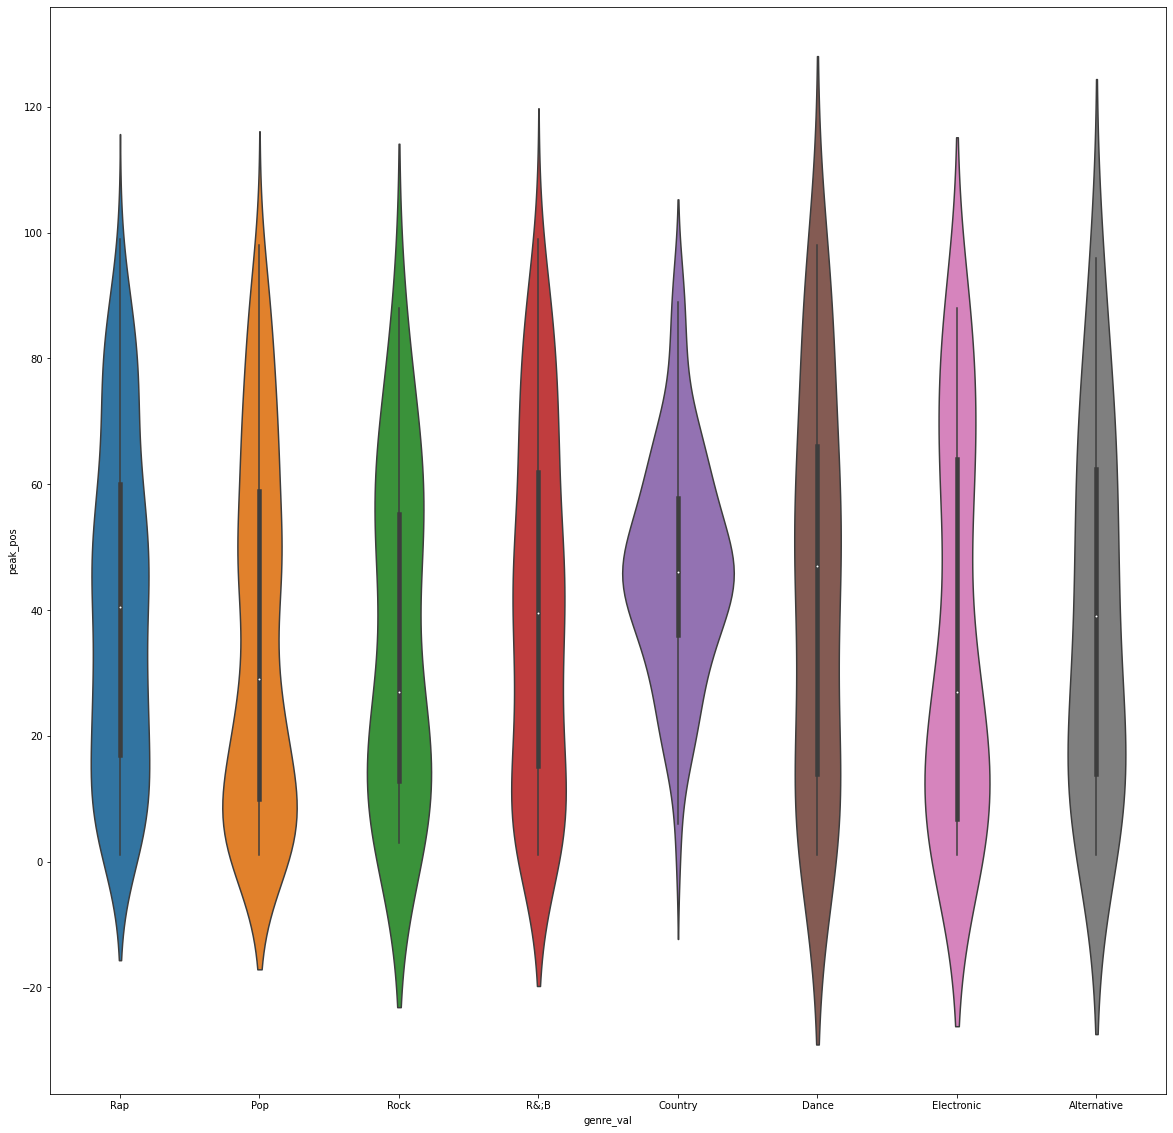

In [140]:
fig, ax = plt.subplots(figsize=(20,20))
sns.violinplot(x="genre_val", y="peak_pos", data=plot_res, ax=ax)
plt.show()

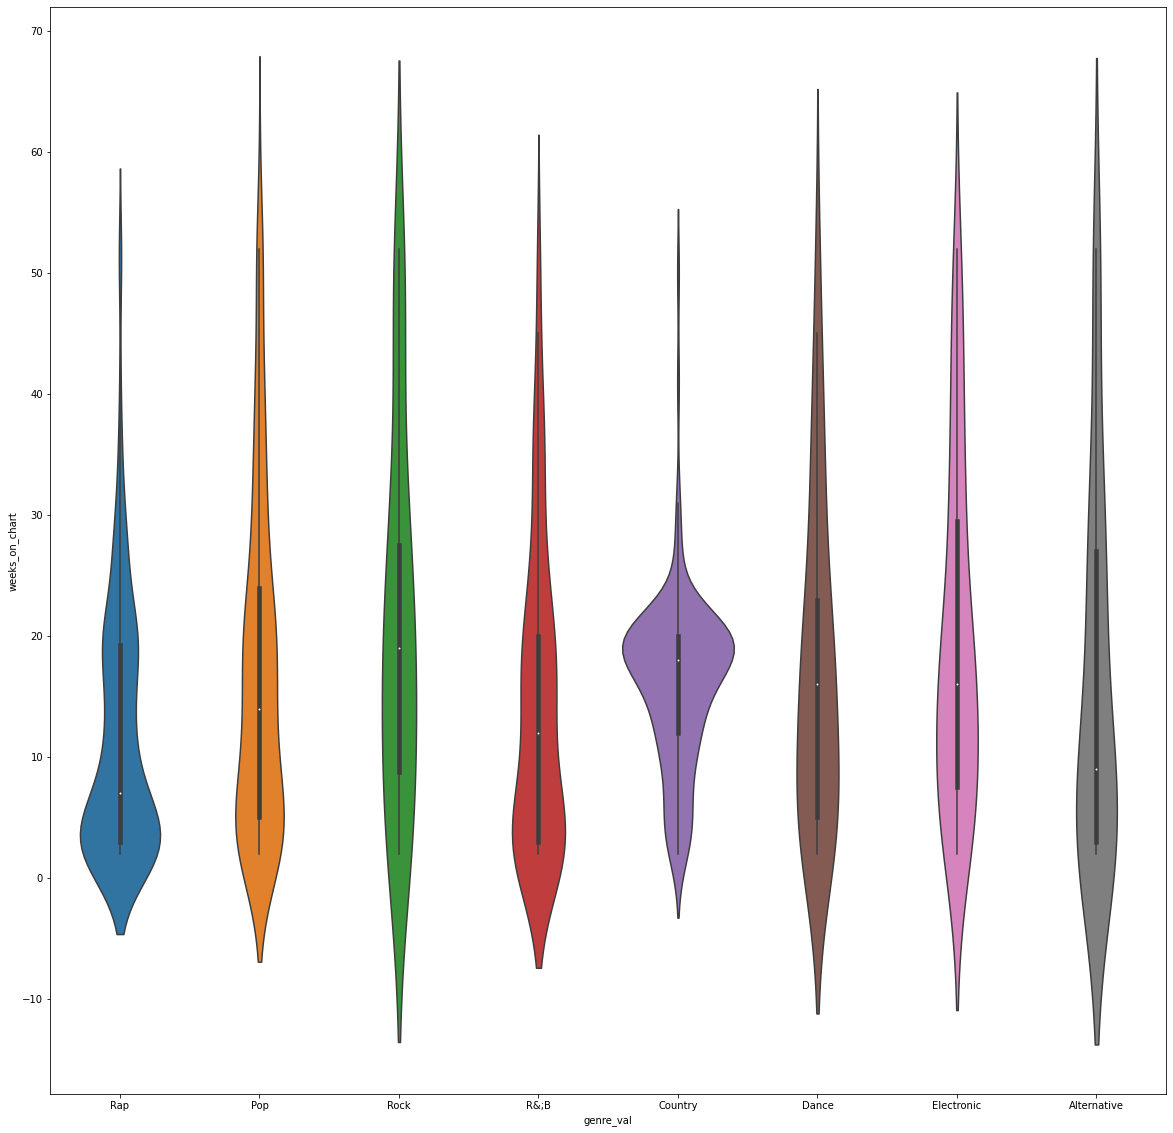

In [141]:
fig, ax = plt.subplots(figsize=(20,20))
sns.violinplot(x="genre_val", y="weeks_on_chart", data=plot_res, ax=ax)
plt.show()